<table width=100%>
  <tr>
    <td>
      <a href="https://colab.research.google.com/github/aurelienmorgan/retrain-pipelines/blob/master/extra/frameworks/Metaflow/metaflow_service.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /></a>
    </td>
    <td width=405>
      <a href="https://pypi.org/project/retrain-pipelines/" target="_blank"><img src="https://github.com/user-attachments/assets/19725866-13f9-48c1-b958-35c2e014351a" width="150" alt="retrain-pipelines" /></a>
      <a href="https://metaflow.org/" target="_blank"><img src="https://github.com/user-attachments/assets/8085a813-d993-47aa-8992-62123fa39967" width="250" alt="Metaflow" /></a>
    </td>
  </tr>
</table>

<b><center><font size=14em>Stateful Metaflow Service & UI</font></center></b>
<center><em><font size=12em>(1/2) Start</font></em></center>

<em>The herein notebook is the accompanied with the <a href="https://github.com/aurelienmorgan/retrain-pipelines/blob/master/extra/frameworks/Metaflow/remote_local_metaflow.ipynb" target="_blank">(2/2) consume</a> Google Colab notebook.</em>

<hr />

<h1>Table of Contents</h1>

- [Fire it up](#scrollTo=1fMs1mgiyXIt)
  - [Establishing Google Drive Sync mechanism](#scrollTo=UMTHePzN7-CF)
  - [Generate a public url for our Metaflow Service+UI](#scrollTo=-03KPONQ-vdE)
  - [Download and launch install script](#scrollTo=GoK0uP7e8FZ5)
- [Monitor &amp; Troubleshoot (need be)](#scrollTo=WSToMfiiN_MY)
  - [Google Drive sync](#scrollTo=De8nVtMpTqxQ)
  - [Nginx reverse proxy](#scrollTo=EJrF7NyNU8l6)
  - [UDocker containers](#scrollTo=9sZ6U-prTwz5)
  - [UDocker Metaflow DB](#scrollTo=z7PcCaYkT6-3)
  - [UDocker Metaflow Service (API/SDK)](#scrollTo=WsGElFSrUD4T)
  - [UDocker Metaflow UI backend service](#scrollTo=ffvayHXoUMW4)
- [Validate your service is operational](#scrollTo=EXoCso7Nlt-o)
  - [Metaflow API](#scrollTo=0QegaCDhwL6B)
  - [Metaflow SDK](#scrollTo=Oj_jAwzfwPOV)
- [Soft shutdown](#scrollTo=II1mo1lVwVzA)
- [Extra](#scrollTo=-rtlfRx3ypRX)

# Fire it up

Start by mounting a Google Drive for statefulness&nbsp;:

In [ ]:
from google.colab import drive
# grant all permission or it fails
drive.mount('/content/drive')

Set the location on the mounted drive where the Stateful Metaflow shall be placed (stateful database, datastore and logs)&nbsp;:

In [ ]:
MF_ROOT = "/content/drive/MyDrive/Metaflow_hf"  # <= change this to any directory under /content/drive/
PGDATA_DIR = "/content/pgdata"

For a fresh start, uncomment and execute the below cell ↠

In [ ]:
# !killall inotifywait

# import os

# directories = [
#     f"{MF_ROOT}/pgdata/",
#     PGDATA_DIR,
#     f"{MF_ROOT}/local_datastore/"
# ]
# for directory in directories:
#     if os.path.exists(directory):
#         print(f"Cleaning up directory: {directory}")
#         for root, dirs, files in os.walk(directory, topdown=False):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 os.remove(file_path)
#             for dir in dirs:
#                 dir_path = os.path.join(root, dir)
#                 if not os.listdir(dir_path):
#                     os.rmdir(dir_path)
#         os.rmdir(directory)

<hr />

## Establishing Google Drive Sync mechanism

Since gdrive can't be used directly to store pgdata (due to PostgreSQL's WAL (Write-Ahead Logging) not being supported there), we use <code>inotifywait</code> to monitor changes and keep drive in sync via <code>rsync</code>. Best effort given so it can stop gracefully.

In [ ]:
!apt-get install inotify-tools

import os
import shutil

local_dir = PGDATA_DIR
drive_dir = f"{MF_ROOT}/pgdata/"
log_file = f"{MF_ROOT}/logs/db_drive_sync_output.log"
datastore_dir = f"{MF_ROOT}/local_datastore/"

os.makedirs(os.path.join(
                    os.path.dirname(log_file),
                    "postgresql"
                ),
            exist_ok=True)
if os.path.isdir(drive_dir):
    shutil.copytree(drive_dir, local_dir,
                    ignore=shutil.ignore_patterns("postmaster.pid"))
else:
    os.makedirs(drive_dir)
    os.makedirs(local_dir)

if not os.path.isdir(datastore_dir):
    os.makedirs(datastore_dir)

sync_script = f"""
nohup bash -c '
inotifywait -m -r -e modify,create,delete --format "%w%f" {local_dir} | while read file; do
    timestamp=$(date "+%Y-%m-%d %H:%M:%S")
    echo "File: $file modified at: $timestamp" >> {log_file}
    parent_dir=$(dirname "$file")
    # Sync only the parent directory
    rsync -rtuq --delete --quiet \
          "$parent_dir/" \
          "{drive_dir}/$(realpath --relative-to="{local_dir}" "$parent_dir")/"

done
' >> {log_file} 2>&1 &
"""

# Execute the sync script
os.system(sync_script)

print("Db-to-gdrive sync started.")
print(f"Check the log file at {log_file} for traces.")

## Generate a public url for your Metaflow Service+UI

<a href="https://developers.cloudflare.com/cloudflare-one/connections/connect-networks/do-more-with-tunnels/trycloudflare/" target="_blan"><img src="https://github.com/user-attachments/assets/f467fb12-315a-47d3-9ea9-7ca65f63dca4" width=150px /></a>

There are alternative solutions out there for this. We rely on the great <b>Cloudflare</b> for url tunelling for many reasons&nbsp;: It's great, free, and doesn't even require an account&nbsp;! Thankful.<br />
<em><small>Note, we initially tried only using Google Colab for external url generation&nbsp;:
```python
from google.colab.output import eval_js
ext_7860_url = eval_js( "google.colab.kernel.proxyPort(7860, {'cache': true})" )
print(ext_7860_url)
```
It does however not satisfy Metaflow UI requirements for heartbeat and other subtilities (pinpoints to weird Google ".internal" urls..) so we had to drop it.</small></em>

In [ ]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared
!mv cloudflared /usr/local/bin/
!nohup cloudflared tunnel --url http://localhost:7860 \
    > {MF_ROOT}/logs/cloudflared_7860.log 2>&1 &
!sleep 15;

In [ ]:
!cat {MF_ROOT}/logs/cloudflared_7860.log

In [ ]:
tunnel_url = !grep -o 'https://[^ ]*' {MF_ROOT}/logs/cloudflared_7860.log | grep -Pv 'https://(.*\.)?((developers\.cloudflare|github)\.com|.*website-terms.*)'
tunnel_url = tunnel_url[0]
print(tunnel_url)

<hr />

## Download and launch install script

In [ ]:
startup_url = \
    "https://raw.githubusercontent.com/aurelienmorgan/retrain-pipelines/refs/heads/master/extra/frameworks/Metaflow/" + \
    "startup.sh"

!curl -# -o startup.sh {startup_url}

In [ ]:
# !cat startup.sh

In [ ]:
!export MF_ROOT={MF_ROOT} && \
 export PGDATA_DIR={PGDATA_DIR} && \
 export UI_EXT_URL={tunnel_url} && \
 sed -i 's/\r$//' startup.sh && \
 chmod +x startup.sh && ./startup.sh

Now, you can browse from either of the below 2 urls (whichever has fastest browsing experience for you)&nbsp;:

In [ ]:
from google.colab.output import eval_js
ext_7860_url = eval_js( "google.colab.kernel.proxyPort(7860, {'cache': true})" )
# ext_7860_url = eval_js( "google.colab.kernel.proxyPort(7860)" )
print(ext_7860_url)

In [ ]:
print(tunnel_url)

Note that <u>to use the Metaflow API & SDK remotely</u> <em>(from another Google Colab notebook)</em>, you must use the <b>Cloudflare</b> tunnel url.

<hr />

# Monitor &amp; Troubleshoot (need be)
[page top](#scrollTo=aiCVGlwDRy25)

In [ ]:
# !ls -l -a {MF_ROOT}/local_datastore/.metaflow/mf.cards/HelloWorldFlow/runs

## Google Drive sync

BEWARE&nbsp;: If you terminate the runtime less than 3 minutes following a start of the Stateful Metaflow service, chances are that you end up with a corrupted database. Basically, you shall always at least wait for the db warmup to complete and regular checkpointing to operate, which translates with a trace (next cell) ending like the whole below sequence&nbsp;:
<center>
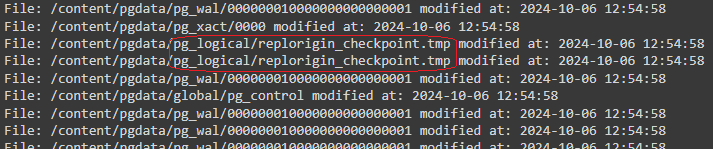
</center>

In [ ]:
# feed of PostgreSQL data-files being synched to Google Drive (run to refresh)
!tail -n 50 {MF_ROOT}/logs/db_drive_sync_output.log

## Nginx reverse proxy

In [ ]:
# !cat /etc/nginx/sites-available/default

In [ ]:
!nginx -v

## UDocker containers

In [ ]:
!udocker --allow-root ps -m -s -p

## UDocker Metaflow DB

In [ ]:
!tail -n 50 {MF_ROOT}/logs/udocker_db.log

In [ ]:
import psycopg2

try:
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        database="postgres",
        user="postgres",
        password="postgres"
    )
    print("Connection successful!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

In [ ]:
!psql -h localhost -p 5432 -U postgres -c "SELECT * FROM (SELECT * FROM \"metadata_v3\" ORDER BY task_id DESC LIMIT 100) AS tab ORDER BY task_id;"

## UDocker Metaflow Service (API/SDK)

In [ ]:
!tail -n 200 {MF_ROOT}/logs/udocker_service.log

In [ ]:
!curl -X GET http:/localhost:8888/ping

In [ ]:
!curl -X GET {tunnel_url}/service/ping

In [ ]:
!curl -X GET http:/localhost:8888/flows/HelloWorldFlow/runs/792/steps/flow_card/tasks/3068

In [ ]:
!curl -X GET http:/localhost:8888/flows/HelloWorldFlow/runs/792/steps/_parameters

## UDocker Metaflow UI backend service

In [ ]:
!tail -n 50 {MF_ROOT}/logs/udocker_ui_backend.log

In [ ]:
!curl -X GET http:/localhost:8083/ping

In [ ]:
!curl -X GET http://localhost:7860/ui_backend_service/ping

In [ ]:
!curl -X GET {tunnel_url}/ping

In [ ]:
!curl -X GET {tunnel_url}/ui_backend_service/ping

In [ ]:
!tail -n 20 {MF_ROOT}/logs/udocker_ui.log

In [ ]:
!curl -X GET http://0.0.0.0:3000/

<hr />

# Validate your service is operational

Also it is not advised to execute a Metaflow flow run on the same runtime as the one hosting Metaflow (due to Google Colab runtimes only having 2 CPU cores), we can still validate from here that all is operational by executing a minimalist <em>Hello World</em> flow run.

In [ ]:
import os ; os.cpu_count()

## Metaflow API

First, lets declare the <em>Hello World</em> flow, to which we add a <code>flow_card</code> task, just so we can confirm that the local card store is all right as well.

In [ ]:
%%writefile hello_world_flow.py
from metaflow import FlowSpec, step, current, card
from metaflow.cards import Markdown

class HelloWorldFlow(FlowSpec):

    @step
    def start(self):
        print("Hello, World!")
        self.next(self.flow_card)

    @card(id='default')
    @step
    def flow_card(self):
        print("blabla")
        current.card['default'].append(Markdown("blabla"))
        self.next(self.end)

    @step
    def end(self):
        print("Flow Finished")

if __name__ == '__main__':
    HelloWorldFlow()

Now, we can launch the flow run. Doing so with our Metaflow service requires some tweaking, as shown below&nbsp;:

In [ ]:
! export METAFLOW_SERVICE_URL=http://localhost:8888/ && \
  export METAFLOW_DEFAULT_METADATA=service && \
  export METAFLOW_DEFAULT_DATASTORE='local' && \
  export METAFLOW_DATASTORE_SYSROOT_LOCAL={MF_ROOT}/local_datastore/ && \
  export USERNAME=user && \
  cd {MF_ROOT}/local_datastore/ && \
  python /content/hello_world_flow.py run

Now, go browse the UI at the external URL generated earlier here and, see that all is fine there. Look for the green dot, top-right corner of the UI, and confirm that flow cards show successfully too.

<center><img border="0" src="https://github.com/user-attachments/assets/65526631-a119-48ec-8c86-f6f826365a65" /></center>

<hr />

## Metaflow SDK

Time to install the <code>metaflow</code> python package.

In [ ]:
!pip install metaflow

We can programatically navigate our artifacts. Comparatively to how we called the API, do do so with our Metaflow service, we need to set some environment variables prior to importing the <code>metaflow</code> python package as shown below&nbsp;:

In [ ]:
import os
os.environ['METAFLOW_SERVICE_URL'] = 'http://localhost:8888/'
os.environ['METAFLOW_DEFAULT_METADATA'] = 'service'
os.environ['USERNAME'] = 'user'

import metaflow

Now, we can for instance query for the last 10 flow runs&nbsp;:

In [ ]:
list(metaflow.Flow("HelloWorldFlow").runs())[0:10]

We can also for instance display the metadata of the last <code>HelloWorldFlow</code> flow run's <code>flow_card</code> task&nbsp;:

In [ ]:
flow_card_task = list(metaflow.Step(
    f"HelloWorldFlow/{metaflow.Flow('HelloWorldFlow').latest_run.id}/flow_card"
).tasks())[0]
flow_card_task.__dict__

Finally, to conclude with our validation of the Metaflow service operationality, we can display the actual flow card generated during that last <code>HelloWorldFlow</code> flow run&nbsp;:

In [ ]:
flow_default_card = metaflow.cards.get_cards(flow_card_task)[0]
print(os.path.realpath(os.path.join(flow_card_task.metadata_dict.get("ds-root", None),
                                    metaflow.metaflow_config.CARD_SUFFIX, flow_default_card.path)))
display(flow_default_card)

<hr />

# Soft shutdown

In [ ]:
# !pkill cloudflared

In [ ]:
# ensuring wal checkpointing, then synching
!sleep 40 && \
 rsync -rtuq --delete --quiet {local_dir} {drive_dir}

# Extra
[page top](#scrollTo=aiCVGlwDRy25)

Programmatically generate the ToC for this notebook with valid links anchors.

In [ ]:
from google.colab import _message
from IPython.display import HTML, display
import re

def get_notebook_content():
    try:
        response = _message.blocking_request('get_ipynb', timeout_sec=120)
        if 'ipynb' in response and isinstance(response['ipynb'], dict):
            return response['ipynb'].get('cells', [])
        else:
            print("Unexpected response structure. Unable to retrieve notebook content.")
            return []
    except Exception as e:
        print(f"An error occurred while retrieving notebook content: {str(e)}")
        return []

def create_toc():
    toc = []
    cells = get_notebook_content()

    toc.append((0, "page top", cells[0].get("metadata").get("id")))
    for cell in cells[1:]:
        if cell.get("cell_type") == "markdown":
            source = cell.get("source", "")
            if isinstance(source, list):
                source = ''.join(source)
            lines = source.split('\n')
            for line in lines:
                match = re.match(r'^(#+)\s+(.*)', line)
                if match:
                    level = len(match.group(1))
                    title = match.group(2).strip()
                    cell_id = cell.get("metadata").get("id")
                    toc.append((level, title, cell_id))

    return toc

def markdown_toc():
    toc = create_toc()
    if not toc:
        return

    _, _, page_top_id = toc.pop(0)
    markdown_toc = f"[page top](#scrollTo={page_top_id})\n\n---\n\n"
    markdown_toc += "<h1>Table of Contents</h1>\n\n"
    for level, title, cell_id in toc:
        markdown_toc += f"{'  ' * (level - 1)}- [{title}](#scrollTo={cell_id})\n"

    return markdown_toc

print(markdown_toc())

[page top](#scrollTo=aiCVGlwDRy25)

---

<h1>Table of Contents</h1>

- [Fire it up](#scrollTo=1fMs1mgiyXIt)
  - [Establishing Google Drive Sync mechanism](#scrollTo=UMTHePzN7-CF)
  - [Generate a public url for your Metaflow Service+UI](#scrollTo=-03KPONQ-vdE)
  - [Download and launch install script](#scrollTo=GoK0uP7e8FZ5)
- [Monitor &amp; Troubleshoot (need be)](#scrollTo=WSToMfiiN_MY)
  - [Google Drive sync](#scrollTo=De8nVtMpTqxQ)
  - [Nginx reverse proxy](#scrollTo=EJrF7NyNU8l6)
  - [UDocker containers](#scrollTo=9sZ6U-prTwz5)
  - [UDocker Metaflow DB](#scrollTo=z7PcCaYkT6-3)
  - [UDocker Metaflow Service (API/SDK)](#scrollTo=WsGElFSrUD4T)
  - [UDocker Metaflow UI backend service](#scrollTo=ffvayHXoUMW4)
- [Validate your service is operational](#scrollTo=EXoCso7Nlt-o)
  - [Metaflow API](#scrollTo=0QegaCDhwL6B)
  - [Metaflow SDK](#scrollTo=Oj_jAwzfwPOV)
- [Soft shutdown](#scrollTo=II1mo1lVwVzA)
- [Extra](#scrollTo=-rtlfRx3ypRX)